# Stable Diffusion with 🤗 Diffusers

**Pedro Cuenca, Patrick von Platen, Suraj Patil, Jeremy Howard**

Chances are you'll have seen examples in Twitter (and elsewhere) of images generated by typing a short description of the scene you want to create. This is the culmination of years of work in generative models. This notebook introduces Stable Diffusion, the highest-quality open source text to image model as of now. It's also small enough to run in consumer GPUs rather than in a datacenter. We use the 🤗 Hugging Face [🧨 Diffusers library](https://github.com/huggingface/diffusers), which is currently our recommended library for using diffusion models.

As we'll see during the course, understanding state-of-the-art generative models requires a deep understanding of many of the fundamental blocks in modern machine learning models. This notebook shows what Stable Diffusion can do and a glimpse of its main components.

_If you open this notebook in Colab, or if you get type errors when generating your first image, please uncomment and run the following cell._

In [1]:
!pip install -Uq diffusers transformers fastcore

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 989.1/989.1 kB 9.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 106.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 30.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 76.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 90.9 MB/s eta 0:00:00


## Using Stable Diffusion

To run Stable Diffusion on your computer you have to accept the model license. It's an open CreativeML OpenRail-M license that claims no rights on the outputs you generate and prohibits you from deliberately producing illegal or harmful content. The [model card](https://huggingface.co/CompVis/stable-diffusion-v1-4) provides more details. If you do accept the license, you need to be a registered user in 🤗 Hugging Face Hub and use an access token for the code to work. You have two options to provide your access token:

* Use the `huggingface-cli login` command-line tool in your terminal and paste your token when prompted. It will be saved in a file in your computer.
* Or use `notebook_login()` in a notebook, which does the same thing.

In [2]:
import logging
from pathlib import Path

import matplotlib.pyplot as plt
import torch
from diffusers import StableDiffusionPipeline
from fastcore.all import concat
from huggingface_hub import notebook_login
from PIL import Image

logging.disable(logging.WARNING)

torch.manual_seed(1)
if not (Path.home()/'.cache/huggingface'/'token').exists(): notebook_login()

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

---

## Looking inside the pipeline

The inference pipeline is just a small piece of code that plugs the components together and performs the inference loop. [This is all there it to is](https://github.com/huggingface/diffusers/blob/main/src/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py#L204).

We'll go through the process of loading and plugging the pieces to see how we could have written it ourselves. We'll start by loading all the modules that we need from their pretrained weights.

First, we need the text encoder and the tokenizer. These come from the text portion of a standard CLIP model, so we'll use the weights released by Open AI.

In [3]:
from transformers import CLIPTextModel, CLIPTokenizer

In [4]:
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16)
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16).to("cuda")

Next we'll load the `vae` and the `unet`. These are distinct models whose weights are stored inside folders of the Stable Diffusion repository. We can use the `subfolder` argument to refer to [these locations](https://huggingface.co/CompVis/stable-diffusion-v1-4/tree/main).

In [5]:
from diffusers import AutoencoderKL, UNet2DConditionModel

In [6]:
# Here we use a different VAE to the original release, which has been fine-tuned for more steps
vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-ema", torch_dtype=torch.float16).to("cuda")
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet", torch_dtype=torch.float16).to("cuda")

To make things a bit different, we'll use another scheduler. The standard pipeline uses the [PNDM Scheduler](https://arxiv.org/abs/2202.09778), but we'll use [Katherine Crowson's](https://github.com/crowsonkb) excellent K-LMS scheduler.

We need to be careful to use the same noising schedule that was used during training. The schedule is defined by the number of noising steps and the amount of noise added at each step, which is derived from the _beta_ parameters.

In the case of the k-LMS scheduler, this is how the betas evolve during the 1000 steps of the noising process used during training:

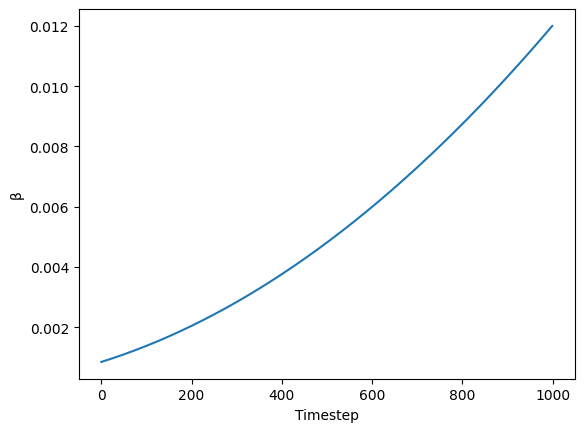

In [7]:
beta_start,beta_end = 0.00085,0.012
plt.plot(torch.linspace(beta_start**0.5, beta_end**0.5, 1000) ** 2)
plt.xlabel('Timestep')
plt.ylabel('β');

In [8]:
from diffusers import LMSDiscreteScheduler

In [9]:
scheduler = LMSDiscreteScheduler(beta_start=beta_start, beta_end=beta_end, beta_schedule="scaled_linear", num_train_timesteps=1000)

We now define the parameters we'll use for generation.

In contrast with the previous examples, we set `num_inference_steps` to 70 to get an even more defined image.

In [10]:
prompt = ["an oil painting of a horse"]

height = 512
width = 512
num_inference_steps = 70
guidance_scale = 7.5
batch_size = 1

We tokenize the prompt. The model requires the same number of tokens for every prompt, so padding is used to ensure we meet the required length.

In [11]:
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
text_embeddings = text_encoder(text_input.input_ids.to("cuda"))[0].half()

In [12]:
ref_embeddings = text_embeddings.detach().clone().to("cuda").half()

We also get the embeddings required to perform unconditional generation, which is achieved with an empty string: the model is free to go in whichever direction it wants as long as it results in a reasonably-looking image. These embeddings will be applied to apply classifier-free guidance.

In [13]:
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
uncond_embeddings = text_encoder(uncond_input.input_ids.to("cuda"))[0].half()

For classifier-free guidance, we need to do two forward passes. One with the conditioned input (`text_embeddings`), and another with the unconditional embeddings (`uncond_embeddings`). In practice, we can concatenate both into a single batch to avoid doing two forward passes.

In [14]:
emb = torch.cat([uncond_embeddings, text_embeddings])

To start the denoising process, we start from pure Gaussian (normal) noise. These are our initial latents.

In [81]:
torch.manual_seed(100)
latents = torch.randn((batch_size, unet.in_channels, height // 8, width // 8))
latents = latents.to("cuda").half()

<ipython-input-81-d2177af172ba>:2: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((batch_size, unet.in_channels, height // 8, width // 8))


In [82]:
init_latents = latents.detach().clone().to("cuda").half()

In [83]:
scheduler.set_timesteps(num_inference_steps)

We scale the initial noise by the standard deviation required by the scheduler. This value will depend on the particular scheduler we use.

In [84]:
latents = latents * scheduler.init_noise_sigma

We are ready to write the denoising loop. The timesteps go from `999` to `0` (1000 steps that were used during training) following a particular schedule.

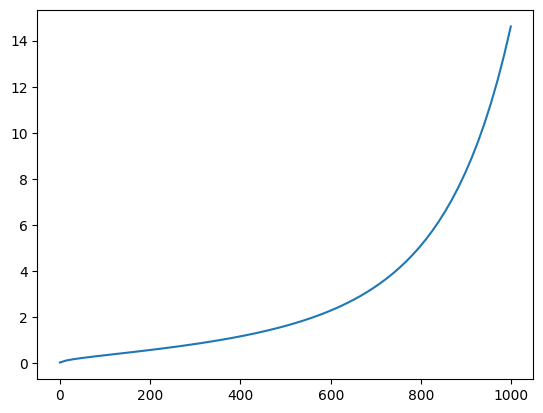

In [85]:
plt.plot(scheduler.timesteps, scheduler.sigmas[:-1]);

In [86]:
scheduler.timesteps

tensor([999.0000, 984.5217, 970.0435, 955.5652, 941.0870, 926.6087, 912.1304,
        897.6522, 883.1739, 868.6957, 854.2174, 839.7391, 825.2609, 810.7826,
        796.3043, 781.8261, 767.3478, 752.8696, 738.3913, 723.9130, 709.4348,
        694.9565, 680.4783, 666.0000, 651.5217, 637.0435, 622.5652, 608.0870,
        593.6087, 579.1304, 564.6522, 550.1739, 535.6957, 521.2174, 506.7391,
        492.2609, 477.7826, 463.3043, 448.8261, 434.3478, 419.8696, 405.3913,
        390.9130, 376.4348, 361.9565, 347.4783, 333.0000, 318.5217, 304.0435,
        289.5652, 275.0870, 260.6087, 246.1304, 231.6522, 217.1739, 202.6957,
        188.2174, 173.7391, 159.2609, 144.7826, 130.3043, 115.8261, 101.3478,
         86.8696,  72.3913,  57.9130,  43.4348,  28.9565,  14.4783,   0.0000],
       dtype=torch.float64)

In [87]:
scheduler.sigmas

tensor([14.6146, 13.3974, 12.3033, 11.3184, 10.4301,  9.6279,  8.9020,  8.2443,
         7.6472,  7.1044,  6.6102,  6.1594,  5.7477,  5.3709,  5.0258,  4.7090,
         4.4178,  4.1497,  3.9026,  3.6744,  3.4634,  3.2680,  3.0867,  2.9183,
         2.7616,  2.6157,  2.4794,  2.3521,  2.2330,  2.1213,  2.0165,  1.9180,
         1.8252,  1.7378,  1.6552,  1.5771,  1.5031,  1.4330,  1.3664,  1.3030,
         1.2427,  1.1852,  1.1302,  1.0776,  1.0272,  0.9788,  0.9324,  0.8876,
         0.8445,  0.8029,  0.7626,  0.7236,  0.6858,  0.6490,  0.6131,  0.5781,
         0.5438,  0.5102,  0.4770,  0.4443,  0.4118,  0.3795,  0.3470,  0.3141,
         0.2805,  0.2455,  0.2084,  0.1672,  0.1174,  0.0292,  0.0000])

In [88]:
from tqdm.auto import tqdm

In [89]:
for i, t in enumerate(tqdm(scheduler.timesteps)):
    input = torch.cat([latents] * 2)
    input = scheduler.scale_model_input(input, t)

    # predict the noise residual
    with torch.no_grad(): pred = unet(input, t, encoder_hidden_states=emb).sample

    # perform guidance
    pred_uncond, pred_text = pred.chunk(2)
    pred = pred_uncond + guidance_scale * (pred_text - pred_uncond)

    # compute the "previous" noisy sample
    latents = scheduler.step(pred, t, latents).prev_sample

  0%|          | 0/70 [00:00<?, ?it/s]

After this process complets our `latents` contain the denoised representation of the image. We use the `vae` decoder to convert it back to pixel space.

In [91]:
def latents_to_pil(latents):
  with torch.no_grad(): image = vae.decode(1 / 0.18215 * latents).sample
  image = (image / 2 + 0.5).clamp(0, 1)
  image = image[0].detach().cpu().permute(1, 2, 0).numpy()
  image = (image * 255).round().astype("uint8")

  return image

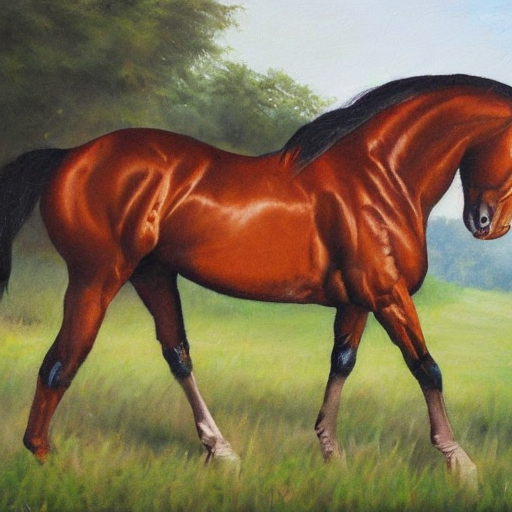

In [92]:
ref_img = latents_to_pil(latents)
Image.fromarray(ref_img)

## DiffEdit

### Step 1: Compute Mask
1. Add noise to input image (in latent space)
2. Denoise noisy latent conditioned on query text
3. Denoise noisy latent conditioned on reference text
4. Subtract the results to get a mask. (Values closer to zero will represent the background).

In [93]:
# create query_embeddings
query_prompt = ["an oil painting of a zebra"]
query_input = tokenizer(query_prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
query_embeddings = text_encoder(query_input.input_ids.to("cuda"))[0].half()

In [94]:
q_emb = torch.cat([uncond_embeddings, query_embeddings])
r_emb = torch.cat([uncond_embeddings, ref_embeddings])

In [95]:
start_step = 35 # because strength = 0.5, so 0.5 * 70 = 35
start_sigma = scheduler.sigmas[start_step]

In [96]:
# get predicted denoised image
def get_denoised_img(latents, emb):
  # add noise to input image (in latent space)
  noise = torch.randn((1, unet.in_channels, height//8, width//8))
  noise = noise.to("cuda").half()

  noisy_latents = scheduler.add_noise(latents, noise, timesteps=torch.tensor([scheduler.timesteps[start_step]]))
  noisy_latents = noisy_latents.to("cuda").half()
  input = torch.cat([noisy_latents, noisy_latents])

  with torch.no_grad():
    pred = unet(input, scheduler.timesteps[start_step], encoder_hidden_states=emb).sample

  u, t = pred.chunk(2)
  pred = u + guidance_scale * (t-u)

  return scheduler.step(pred, scheduler.timesteps[start_step], noisy_latents).pred_original_sample

In [101]:
avg_noise_img = torch.zeros((height, width, 3))

for i in range(30):
  # denoise noisy latent conditioned on query text
  query_pred = get_denoised_img(latents, q_emb)

  # denoise noisy latent conditioned on reference text
  ref_pred = get_denoised_img(latents, r_emb)

  avg_noise_img += latents_to_pil(query_pred - ref_pred)

avg_noise_img /= 30

<ipython-input-96-7e7e4f8b629b>:4: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  noise = torch.randn((1, unet.in_channels, height//8, width//8))


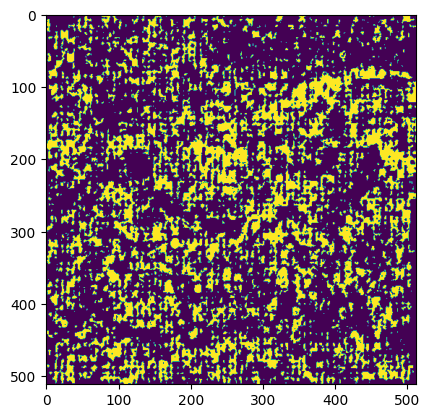

In [107]:
import numpy as np

mask = (avg_noise_img - avg_noise_img.min()) / (avg_noise_img.max()-avg_noise_img.min()) >= 0.5
mask = mask.numpy()
mask = mask.mean(axis=-1).astype("uint8")
plt.imshow(mask)

In [98]:
avg_noise_img.shape

torch.Size([512, 512, 3])

In [39]:
mask[0,0]

0

## Step 2: Encoding

In [108]:
encoding_ratio = 0.7 # best performing according to Appendix 4 of DiffEdit paper
num_encoding_steps = int(encoding_ratio * num_inference_steps)
start_encoding_step = num_inference_steps - num_encoding_steps # because scheduler sigma decreases with idx
scheduler.timesteps[start_encoding_step]

tensor(694.9565, dtype=torch.float64)

In [109]:
encoding_noise = torch.randn((len(query_prompt), unet.in_channels, height//8, width//8))
encoding_noise = encoding_noise.to("cuda").half()

<ipython-input-109-cf05ed4685c1>:1: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  encoding_noise = torch.randn((len(query_prompt), unet.in_channels, height//8, width//8))


In [110]:
encoding_noise_sigma = scheduler.sigmas[start_encoding_step]
encoding_noise_sigma

tensor(3.2680)

In [111]:
encoded_latents = scheduler.add_noise(latents, encoding_noise, timesteps=torch.tensor([scheduler.timesteps[start_encoding_step]]))
encoded_latents = encoded_latents.to("cuda").half()

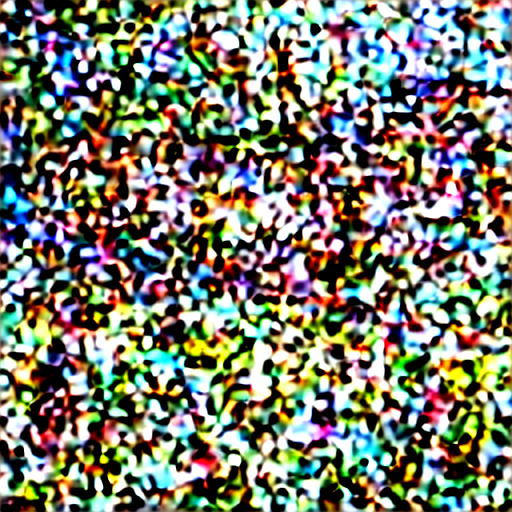

In [113]:
encoded_img = latents_to_pil(encoded_latents)
Image.fromarray(encoded_img)

## Step 3: Decoding with mask guidance
We can treat this as image to image generation, and generate an image based on `query_emb`.

In [114]:
for i,ts in enumerate(tqdm(scheduler.timesteps)):
  if i >= start_encoding_step:
    inp = scheduler.scale_model_input(torch.cat([encoded_latents] * 2), ts)
    with torch.no_grad(): u,t = unet(inp, ts, encoder_hidden_states=q_emb).sample.chunk(2)
    pred = u + guidance_scale*(t-u)
    encoded_latents = scheduler.step(pred, ts, encoded_latents).prev_sample

  0%|          | 0/70 [00:00<?, ?it/s]

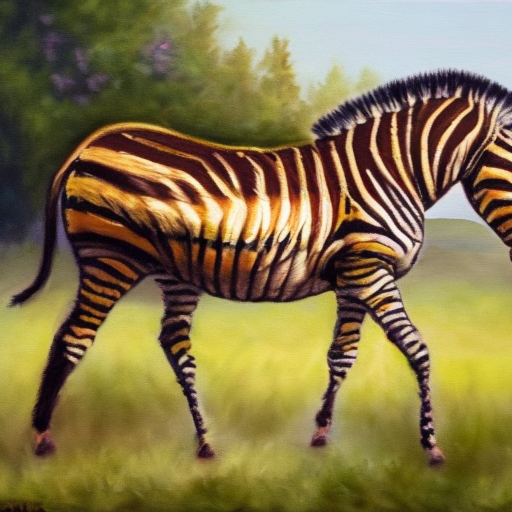

In [115]:
query_img = latents_to_pil(encoded_latents)
Image.fromarray(query_img)

Oddly enough it seems that we do not even need the mask and we already have an image that is very close to the original. That are some small differences in the background (e.g. purple flowers in the `query_img`), but these are almost neglible.

Next we use mask to select this image generated from the query prompt, in order to combine with the (1 - mask) to select the image generated from the reference prompt.

In [120]:
mask = np.expand_dims(mask, axis=2)

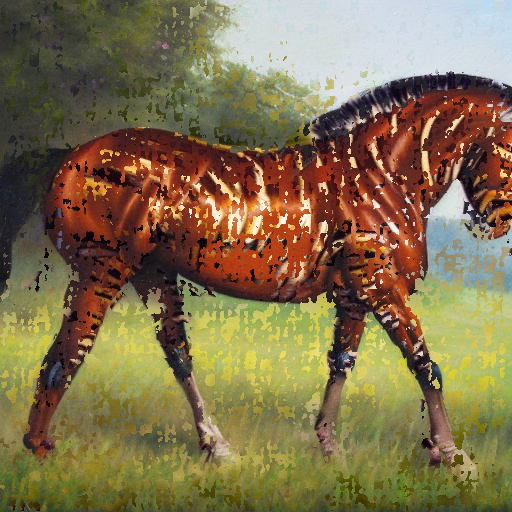

In [121]:
combined_img = mask * query_img + (1 - mask) * ref_img
Image.fromarray(combined_img)

This seems pretty bad because our mask is not smooth enough. Possible improvements are:
1. Using just a single noise difference so that we do not get such 'pixelated' effect.
2. Smoothen the mask by 'infilling' the empty spots wherever possible.